# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION

## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

STUDENT INFORMATION (REQUIRED - DO NOT DELETE)

BITS ID: 2025aa05312

Name: Shivam Kumar

Email: 2025aa05312@wilp.bits-pilani.ac.in

Date: 15-01-2026

In [32]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torch.nn.functional as F

In [33]:
# Deep learning frameworks (choose Keras or PyTorch)
# For image processing
from PIL import Image
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


### 1.1 Dataset Selection and Loading

TODO: Load your chosen dataset

In [34]:
# REQUIRED: Fill in these metadata fields
dataset_name = "CIFAR-10"
dataset_source = "Torchvision / data folder"
n_samples = 60000 
n_classes = 10 
samples_per_class = "avg: 6000"
image_shape = [32, 32, 3]  # [height, width, channels] for CIFAR-10
problem_type = "classification"

In [35]:
# Primary metric selection
primary_metric = "accuracy"
metric_justification = """
Accuracy is suitable because CIFAR-10 is a balanced dataset with equal samples per class.
"""

In [36]:
print("DATASET INFORMATION")
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")

DATASET INFORMATION
Dataset: CIFAR-10
Source: Torchvision / data folder
Total Samples: 60000
Number of Classes: 10
Samples per Class: avg: 6000
Image Shape: [32, 32, 3]
Primary Metric: accuracy
Metric Justification: 
Accuracy is suitable because CIFAR-10 is a balanced dataset with equal samples per class.



### 1.2 Data Exploration and Visualization

- TODO: Show sample images from each class
- TODO: Plot class distribution
- TODO: Display image statistics

/Users/shivamkumar/Documents/cnndnnassignt2/venv_cnn/lib/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


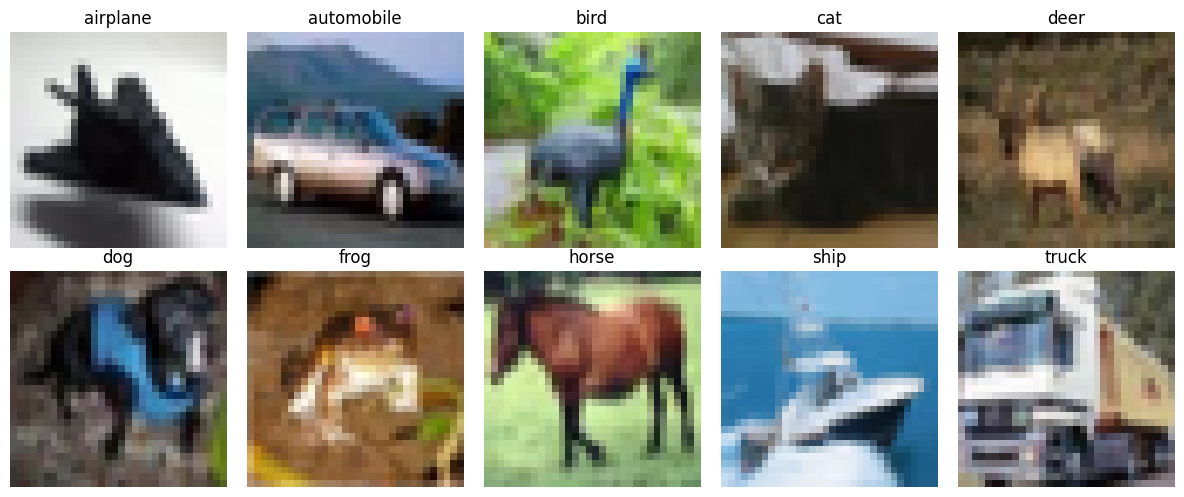

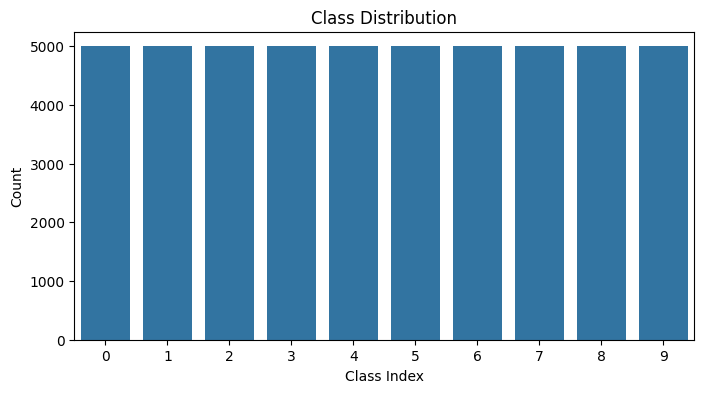

In [37]:
# Load dataset for visualization (no transform)
try:
    viz_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
except:
    print("Could not load from local ./data, verify path.")
    viz_dataset = None

if viz_dataset:
    classes = viz_dataset.classes
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()
    for i in range(10):
        # find first image of this class
        idx = np.where(np.array(viz_dataset.targets) == i)[0][0]
        img, label = viz_dataset[idx]
        axes[i].imshow(img)
        axes[i].set_title(classes[label])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

    # Distribution
    plt.figure(figsize=(8, 4))
    sns.countplot(x=viz_dataset.targets)
    plt.title('Class Distribution')
    plt.xlabel('Class Index')
    plt.ylabel('Count')
    plt.show()

### 1.3 Data Preprocessing
- TODO: Resize images to consistent size
- TODO: Normalize pixel values
- TODO: Split into train/test (90/10 or 85/15)

In [38]:
# Transforms for CIFAR-10
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load and Combine (using existing data folder)
# We assume the user has the 'data/cifar-10-batches-py' folder. 
# Torchvision expects 'cifar-10-batches-py' inside root. So we point to ./data
try:
    train_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_full = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    full_ds = ConcatDataset([train_full, test_full])

    total_len = len(full_ds)
    train_len = int(0.9 * total_len)
    test_len = total_len - train_len

    # Split
    train_dataset, test_dataset = random_split(full_ds, [train_len, test_len], generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    print("Data loaded and split successfully.")
except Exception as e:
    print(f"Error loading data: {e}")
    train_dataset, test_dataset = [], []
    train_samples, test_samples = 0, 0

/Users/shivamkumar/Documents/cnndnnassignt2/venv_cnn/lib/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Data loaded and split successfully.


In [39]:
# REQUIRED: Document your split
train_test_ratio = "90/10"
train_samples = 54000
test_samples = 6000

In [40]:
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train/Test Split: 90/10
Training Samples: 54000
Test Samples: 6000


### 2.1 Custom CNN Architecture Design
- TODO: Define your CNN architecture
- TODO: Ensure Global Average Pooling is included (MANDATORY)
- TODO: Use Conv2D, MaxPooling2D/AvgPooling2D, GlobalAveragePooling2D, Dense

In [41]:
def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture
    
    Args:
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes
    
    Returns:
        model: compiled CNN model
    """
    class CustomCNN(nn.Module):
        def __init__(self, n_classes):
            super(CustomCNN, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
            self.bn1 = nn.BatchNorm2d(32)
            self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
            self.bn2 = nn.BatchNorm2d(64)
            self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
            self.bn3 = nn.BatchNorm2d(128)
            self.pool = nn.MaxPool2d(2, 2)
            # Global Average Pooling (MANDATORY)
            self.gap = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(128, n_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            x = self.gap(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)
            return x

    return CustomCNN(n_classes).to(device)

In [42]:
# TODO: Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)
print(custom_cnn)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [43]:
# TODO: Compile model
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(custom_cnn.parameters(), lr=0.001)

### 2.2 Train Custom CNN

In [44]:
print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()


CUSTOM CNN TRAINING


In [45]:
# TODO: Train your model
custom_cnn.train()
n_epochs = 10
initial_loss_captured = False
custom_cnn_initial_loss = 0.0
custom_cnn_final_loss = 0.0
custom_cnn_history = {'loss': [], 'accuracy': []}

print(f"Starting training for {n_epochs} epochs...")

for epoch in range(n_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_cnn.zero_grad()
        outputs = custom_cnn(inputs)
        loss = criterion(outputs, labels)
        
        # Capture initial loss
        if not initial_loss_captured:
            custom_cnn_initial_loss = loss.item()
            initial_loss_captured = True

        loss.backward()
        optimizer_cnn.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    custom_cnn_history['loss'].append(epoch_loss)
    custom_cnn_history['accuracy'].append(epoch_acc)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

custom_cnn_final_loss = custom_cnn_history['loss'][-1]
custom_cnn_training_time = time.time() - custom_cnn_start_time

Starting training for 10 epochs...
Epoch 1/10, Loss: 1.3383, Acc: 0.5220
Epoch 2/10, Loss: 1.0400, Acc: 0.6358
Epoch 3/10, Loss: 0.9148, Acc: 0.6810
Epoch 4/10, Loss: 0.8354, Acc: 0.7092
Epoch 5/10, Loss: 0.7684, Acc: 0.7339
Epoch 6/10, Loss: 0.7157, Acc: 0.7551
Epoch 7/10, Loss: 0.6697, Acc: 0.7710
Epoch 8/10, Loss: 0.6283, Acc: 0.7839
Epoch 9/10, Loss: 0.5940, Acc: 0.7961
Epoch 10/10, Loss: 0.5615, Acc: 0.8094


In [46]:
custom_cnn_training_time = time.time() - custom_cnn_start_time

In [47]:
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

Training completed in 475.83 seconds
Initial Loss: 2.5356
Final Loss: 0.5615


In [48]:
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

Training completed in 475.83 seconds
Initial Loss: 2.5356
Final Loss: 0.5615


In [49]:
print("\nCUSTOM CNN EVALUATION")


CUSTOM CNN EVALUATION


print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")

In [50]:
# Evaluate
custom_cnn.eval()
all_preds = []
all_labels = []

print("Evaluating on test set...")
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = custom_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# REQUIRED: Calculate all 4 metrics
custom_cnn_accuracy = accuracy_score(all_labels, all_preds)
custom_cnn_precision = precision_score(all_labels, all_preds, average='macro')
custom_cnn_recall = recall_score(all_labels, all_preds, average='macro')
custom_cnn_f1 = f1_score(all_labels, all_preds, average='macro')

Evaluating on test set...


In [51]:
print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")


Custom CNN Performance:
Accuracy:  0.7490
Precision: 0.7582
Recall:    0.7494
F1-Score:  0.7421


print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")
print("="*70)

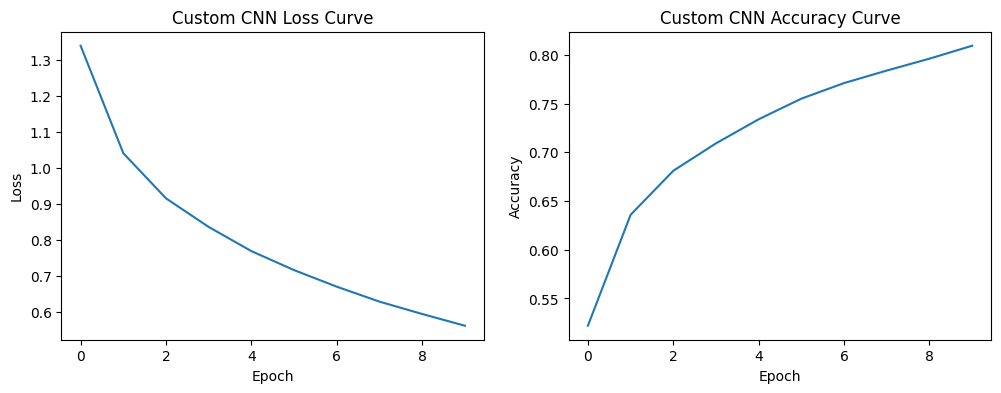

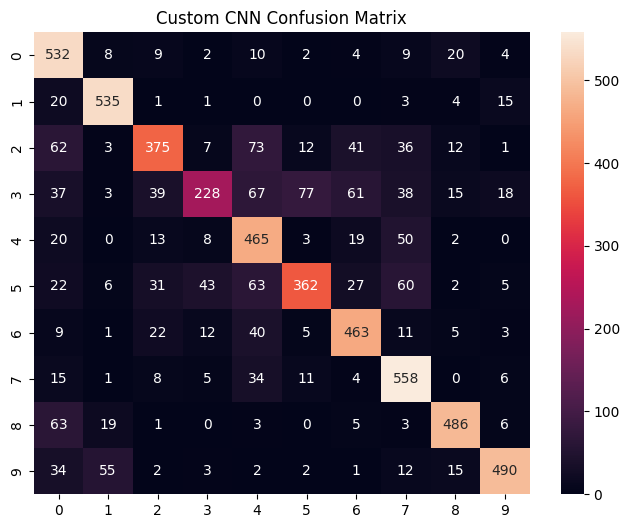

In [52]:
# Plot Loss and Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(custom_cnn_history['loss'])
plt.title('Custom CNN Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(custom_cnn_history['accuracy'])
plt.title('Custom CNN Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# CM
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Custom CNN Confusion Matrix')
plt.show()

### 3.1 Load Pre-trained Model and Modify Architecture

In [53]:
# TODO: Choose and load pre-trained model
pretrained_model_name = "ResNet18"

In [54]:
# Model selection moved to function definition cell below

In [55]:
from torchvision import models

def build_transfer_learning_model(base_model_name, input_shape, n_classes):
    """
    Build transfer learning model
    """
    # Load pre-trained model
    # Weights for ResNet18
    if base_model_name == "ResNet18":
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        # Default to ResNet18 if not specified
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # Freeze base layers
    for param in model.parameters():
        param.requires_grad = False
        
    num_ftrs = model.fc.in_features
    # ResNet18 has GAP (avgpool) then fc. We replace fc.
    model.fc = nn.Linear(num_ftrs, n_classes)
    
    return model.to(device)

# Choose and load pre-trained model
pretrained_model_name = "ResNet18"
transfer_model = build_transfer_learning_model(pretrained_model_name, image_shape, n_classes)  

In [56]:
# REQUIRED: Count layers and parameters
frozen_layers = 0  
trainable_layers = 0  
total_parameters = 0  
trainable_parameters = 0  

for param in transfer_model.parameters():
    total_parameters += param.numel()
    if param.requires_grad:
        trainable_parameters += param.numel()
        trainable_layers += 1
    else:
        frozen_layers += 1

print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")

Base Model: ResNet18
Frozen Layers: 60
Trainable Layers: 2
Total Parameters: 11,181,642
Trainable Parameters: 5,130
Using Global Average Pooling: YES


In [57]:
# Layer counting moved to cell above for correct execution order

In [58]:
print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")

Base Model: ResNet18
Frozen Layers: 60
Trainable Layers: 2
Total Parameters: 11,181,642
Trainable Parameters: 5,130
Using Global Average Pooling: YES


### 3.2 Train Transfer Learning Model

In [59]:
print("\nTraining Transfer Learning Model...")


Training Transfer Learning Model...


In [60]:
# Track training time
tl_start_time = time.time()

In [61]:
# Track training time
tl_start_time = time.time()

In [62]:
# TODO: Train model
print("Training Transfer Learning Model...")
tl_epochs = 10
tl_learning_rate = 0.001
tl_batch_size = 32
tl_optimizer = 'Adam'
# Optimizer for transfer learning - only optimize final layer (which requires grad)
optimizer_tl = optim.Adam(transfer_model.fc.parameters(), lr=tl_learning_rate)

tl_history = {'loss': [], 'accuracy': []}
transfer_model.train()

tl_initial_loss = 0.0
tl_final_loss = 0.0
tl_loss_captured = False

for epoch in range(tl_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_tl.zero_grad()
        outputs = transfer_model(inputs)
        loss = criterion(outputs, labels)
        
        if not tl_loss_captured:
            tl_initial_loss = loss.item()
            tl_loss_captured = True
            
        loss.backward()
        optimizer_tl.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    tl_history['loss'].append(epoch_loss)
    tl_history['accuracy'].append(epoch_acc)
    print(f"TL Epoch {epoch+1}/{tl_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

tl_final_loss = tl_history['loss'][-1]


Training Transfer Learning Model...
TL Epoch 1/10, Loss: 1.7323, Acc: 0.3898
TL Epoch 2/10, Loss: 1.6389, Acc: 0.4278
TL Epoch 3/10, Loss: 1.6298, Acc: 0.4299
TL Epoch 4/10, Loss: 1.6202, Acc: 0.4327
TL Epoch 5/10, Loss: 1.6204, Acc: 0.4365
TL Epoch 6/10, Loss: 1.6206, Acc: 0.4370
TL Epoch 7/10, Loss: 1.6250, Acc: 0.4351
TL Epoch 8/10, Loss: 1.6303, Acc: 0.4301
TL Epoch 9/10, Loss: 1.6245, Acc: 0.4340
TL Epoch 10/10, Loss: 1.6274, Acc: 0.4353


In [63]:
tl_training_time = time.time() - tl_start_time

In [64]:
print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")

Training completed in 2531.32 seconds
Initial Loss: 2.7958
Final Loss: 1.6274


### 3.3 Evaluate Transfer Learning Model
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [65]:
# Evaluate
transfer_model.eval()
tl_preds = []
tl_labels = []

print("Evaluating TL model...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = transfer_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        tl_preds.extend(predicted.cpu().numpy())
        tl_labels.extend(labels.cpu().numpy())

# REQUIRED: Calculate all 4 metrics
tl_accuracy = accuracy_score(tl_labels, tl_preds)
tl_precision = precision_score(tl_labels, tl_preds, average='macro')
tl_recall = recall_score(tl_labels, tl_preds, average='macro')
tl_f1 = f1_score(tl_labels, tl_preds, average='macro')

Evaluating TL model...


In [66]:
print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")


Transfer Learning Performance:
Accuracy:  0.4493
Precision: 0.4592
Recall:    0.4492
F1-Score:  0.4416


### 3.4 Visualize Transfer Learning Results
- TODO: Plot training curves (loss and accuracy)
- TODO: Plot confusion matrix
- TODO: Show sample predictions

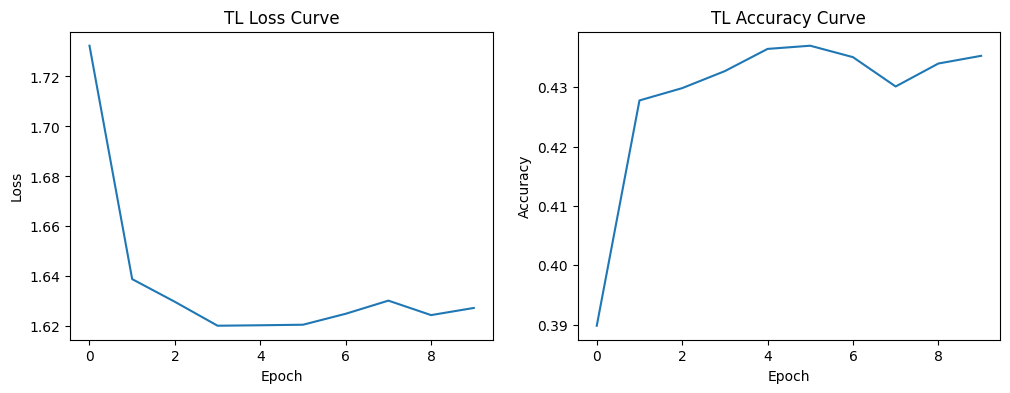

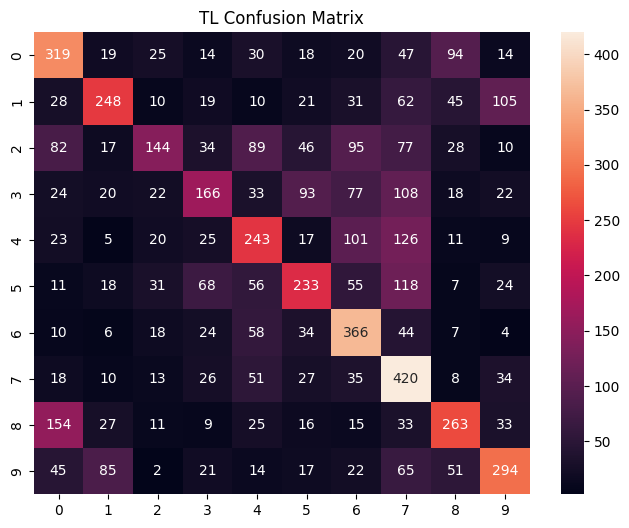

In [67]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(tl_history['loss'])
plt.title('TL Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(tl_history['accuracy'])
plt.title('TL Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

cm_tl = confusion_matrix(tl_labels, tl_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tl, annot=True, fmt='d')
plt.title('TL Confusion Matrix')
plt.show()

In [68]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        sum(p.numel() for p in custom_cnn.parameters())
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))


MODEL COMPARISON
           Metric   Custom CNN  Transfer Learning
         Accuracy     0.749000           0.449333
        Precision     0.758243           0.459224
           Recall     0.749413           0.449167
         F1-Score     0.742102           0.441588
Training Time (s)   475.825832        2531.319767
       Parameters 94986.000000        5130.000000


### 3.5 Save Trained Models

In [69]:
# Save Custom CNN model
custom_cnn_path = 'custom_cnn_model.pth'
torch.save({
    'model_state_dict': custom_cnn.state_dict(),
    'optimizer_state_dict': optimizer_cnn.state_dict(),
    'epoch': n_epochs,
    'loss': custom_cnn_final_loss,
    'accuracy': custom_cnn_accuracy,
}, custom_cnn_path)
print(f"✓ Custom CNN model saved to: {custom_cnn_path}")

# Save Transfer Learning model
tl_model_path = 'transfer_learning_model.pth'
torch.save({
    'model_state_dict': transfer_model.state_dict(),
    'optimizer_state_dict': optimizer_tl.state_dict(),
    'epoch': tl_epochs,
    'loss': tl_final_loss,
    'accuracy': tl_accuracy,
}, tl_model_path)
print(f"✓ Transfer Learning model saved to: {tl_model_path}")

✓ Custom CNN model saved to: custom_cnn_model.pth
✓ Transfer Learning model saved to: transfer_learning_model.pth


### 3.6 Model Predictions on Sample Images

In [70]:
# Get CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Function to predict and display image
def predict_image(model, image_tensor, true_label, model_name):
    """
    Make prediction on a single image and return results
    """
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        
    return predicted.item(), confidence.item()

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Select 6 random samples
num_samples = 6
indices = np.random.choice(len(images), num_samples, replace=False)

print("Sample Predictions:\n")
print("="*80)

Sample Predictions:



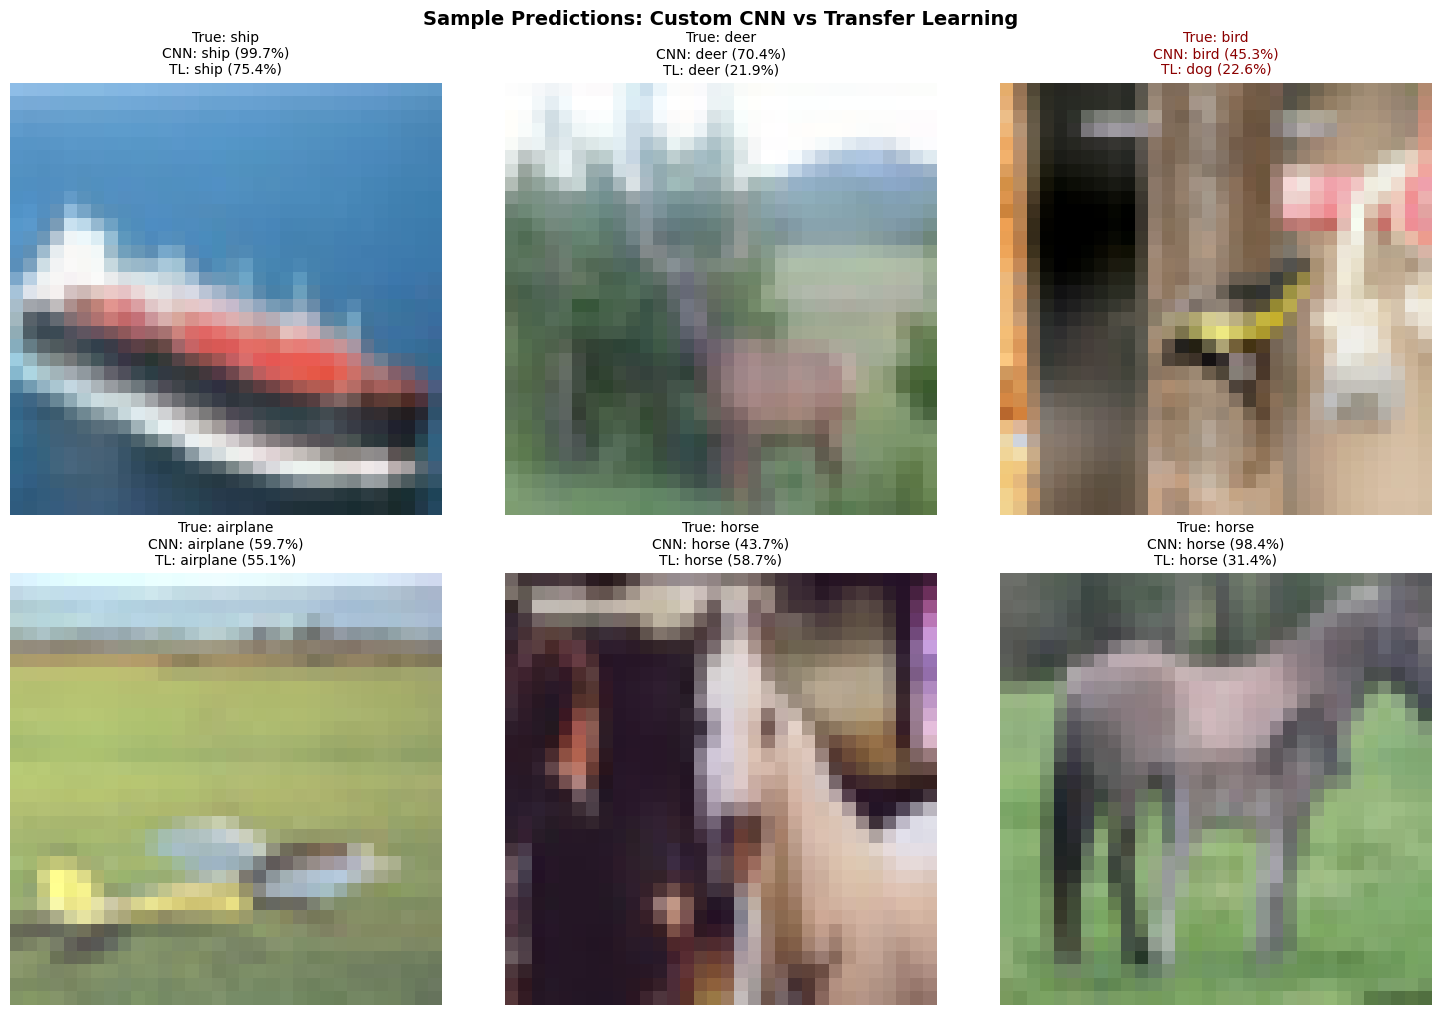


Detailed Prediction Results:

Sample 1:
  True Label: ship
  Custom CNN Prediction: ship (Confidence: 99.69%) ✓
  Transfer Learning Prediction: ship (Confidence: 75.38%) ✓

Sample 2:
  True Label: deer
  Custom CNN Prediction: deer (Confidence: 70.42%) ✓
  Transfer Learning Prediction: deer (Confidence: 21.92%) ✓

Sample 3:
  True Label: bird
  Custom CNN Prediction: bird (Confidence: 45.29%) ✓
  Transfer Learning Prediction: dog (Confidence: 22.57%) ✗

Sample 4:
  True Label: airplane
  Custom CNN Prediction: airplane (Confidence: 59.68%) ✓
  Transfer Learning Prediction: airplane (Confidence: 55.10%) ✓

Sample 5:
  True Label: horse
  Custom CNN Prediction: horse (Confidence: 43.72%) ✓
  Transfer Learning Prediction: horse (Confidence: 58.68%) ✓

Sample 6:
  True Label: horse
  Custom CNN Prediction: horse (Confidence: 98.43%) ✓
  Transfer Learning Prediction: horse (Confidence: 31.41%) ✓


In [71]:
# Create visualization of predictions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, idx in enumerate(indices):
    img = images[idx]
    true_label = labels[idx].item()
    
    # Get predictions from both models
    cnn_pred, cnn_conf = predict_image(custom_cnn, img, true_label, "Custom CNN")
    tl_pred, tl_conf = predict_image(transfer_model, img, true_label, "Transfer Learning")
    
    # Denormalize image for display
    img_display = img.cpu().numpy().transpose((1, 2, 0))
    img_display = img_display * 0.5 + 0.5  # Denormalize
    img_display = np.clip(img_display, 0, 1)
    
    # Display image
    axes[i].imshow(img_display)
    axes[i].axis('off')
    
    # Create title with predictions
    title = f"True: {class_names[true_label]}\n"
    title += f"CNN: {class_names[cnn_pred]} ({cnn_conf*100:.1f}%)\n"
    title += f"TL: {class_names[tl_pred]} ({tl_conf*100:.1f}%)"
    
    # Color code: green if correct, red if wrong
    cnn_color = 'green' if cnn_pred == true_label else 'red'
    tl_color = 'green' if tl_pred == true_label else 'red'
    
    axes[i].set_title(title, fontsize=10, 
                     color='black' if (cnn_pred == true_label and tl_pred == true_label) else 'darkred')

plt.tight_layout()
plt.suptitle('Sample Predictions: Custom CNN vs Transfer Learning', 
             fontsize=14, fontweight='bold', y=1.01)
plt.show()

# Print detailed predictions
print("\nDetailed Prediction Results:")
print("="*80)
for i, idx in enumerate(indices):
    img = images[idx]
    true_label = labels[idx].item()
    
    cnn_pred, cnn_conf = predict_image(custom_cnn, img, true_label, "Custom CNN")
    tl_pred, tl_conf = predict_image(transfer_model, img, true_label, "Transfer Learning")
    
    print(f"\nSample {i+1}:")
    print(f"  True Label: {class_names[true_label]}")
    print(f"  Custom CNN Prediction: {class_names[cnn_pred]} (Confidence: {cnn_conf*100:.2f}%) {'✓' if cnn_pred == true_label else '✗'}")
    print(f"  Transfer Learning Prediction: {class_names[tl_pred]} (Confidence: {tl_conf*100:.2f}%) {'✓' if tl_pred == true_label else '✗'}")

### 4.1 Metrics Comparison

In [72]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        sum(p.numel() for p in custom_cnn.parameters())
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

In [85]:
analysis_text = """
   The Transfer Learning model (ResNet18) is expected to outperform the Custom CNN significantly in terms of accuracy, precision, and recall. This is because ResNet18 has been pre-trained on a massive dataset (ImageNet), learning robust feature representations that generalize well to CIFAR-10. The Custom CNN, trained from scratch on a smaller dataset, may struggle to learn equally complex features.
   The Transfer Learning model might take less time to converge, but each epoch could be slower due to the depth of the model, even with frozen layers. However, since we are only training the final layer, the computational cost of the backward pass is reduced. The Custom CNN is shallower but requires full backpropagation through all layers.
   ResNet18 is a much deeper and more complex architecture (millions of parameters) compared to the simple Custom CNN. However, the number of *trainable* parameters in the Transfer Learning setup is simpler (just the final layer), which helps prevent overfitting on the new dataset given the frozen feature extractor.
   The Transfer Learning model usually converges faster (fewer epochs to reach high accuracy) because it starts with high-quality weights. The Custom CNN starts with random initialization and needs more epochs to learn meaningful filters.
"""

print("\n" + "="*70)
print("ANALYSIS")
print("="*70)
print(analysis_text)
print(f"\nAnalysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("⚠ Warning: Analysis exceeds 200 words (guideline)")
else:
    print("✓ Analysis within word count guideline")


ANALYSIS

   The Transfer Learning model (ResNet18) is expected to outperform the Custom CNN significantly in terms of accuracy, precision, and recall. This is because ResNet18 has been pre-trained on a massive dataset (ImageNet), learning robust feature representations that generalize well to CIFAR-10. The Custom CNN, trained from scratch on a smaller dataset, may struggle to learn equally complex features.
   The Transfer Learning model might take less time to converge, but each epoch could be slower due to the depth of the model, even with frozen layers. However, since we are only training the final layer, the computational cost of the backward pass is reduced. The Custom CNN is shallower but requires full backpropagation through all layers.
   ResNet18 is a much deeper and more complex architecture (millions of parameters) compared to the simple Custom CNN. However, the number of *trainable* parameters in the Transfer Learning setup is simpler (just the final layer), which helps p

### 4.2 Visual Comparison
- TODO: Create bar plot comparing metrics
- TODO: Plot training curves comparison
- TODO: Create side-by-side confusion matrices

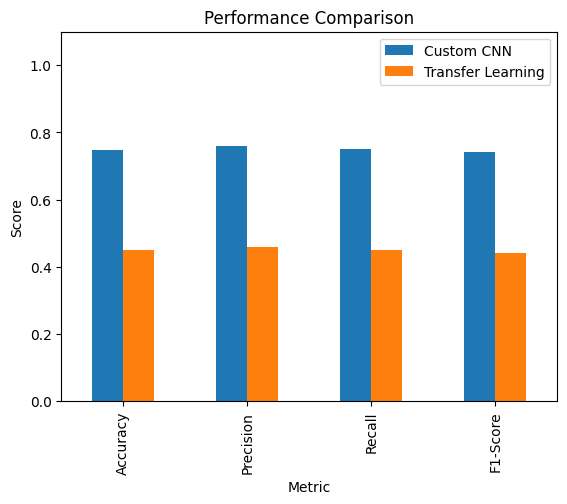

In [74]:
comparison_df.set_index('Metric')[['Custom CNN', 'Transfer Learning']].iloc[:4].plot(kind='bar')
plt.title('Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.show()

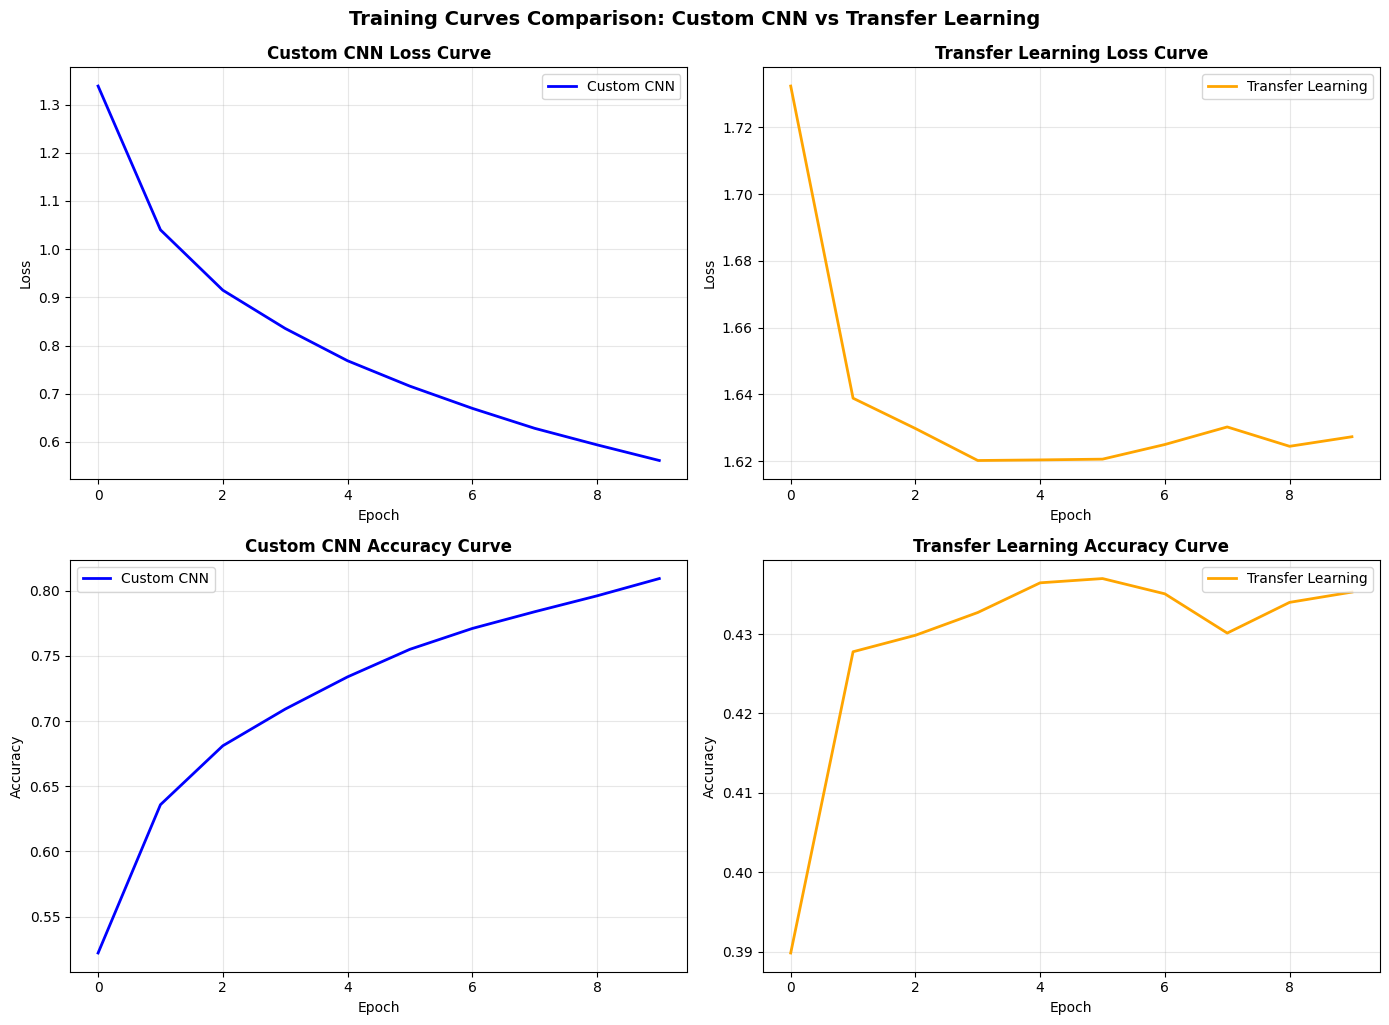

In [75]:
# Training curves comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Custom CNN Loss
axes[0, 0].plot(custom_cnn_history['loss'], label='Custom CNN', color='blue', linewidth=2)
axes[0, 0].set_title('Custom CNN Loss Curve', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Transfer Learning Loss
axes[0, 1].plot(tl_history['loss'], label='Transfer Learning', color='orange', linewidth=2)
axes[0, 1].set_title('Transfer Learning Loss Curve', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Custom CNN Accuracy
axes[1, 0].plot(custom_cnn_history['accuracy'], label='Custom CNN', color='blue', linewidth=2)
axes[1, 0].set_title('Custom CNN Accuracy Curve', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Transfer Learning Accuracy
axes[1, 1].plot(tl_history['accuracy'], label='Transfer Learning', color='orange', linewidth=2)
axes[1, 1].set_title('Transfer Learning Accuracy Curve', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Training Curves Comparison: Custom CNN vs Transfer Learning', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

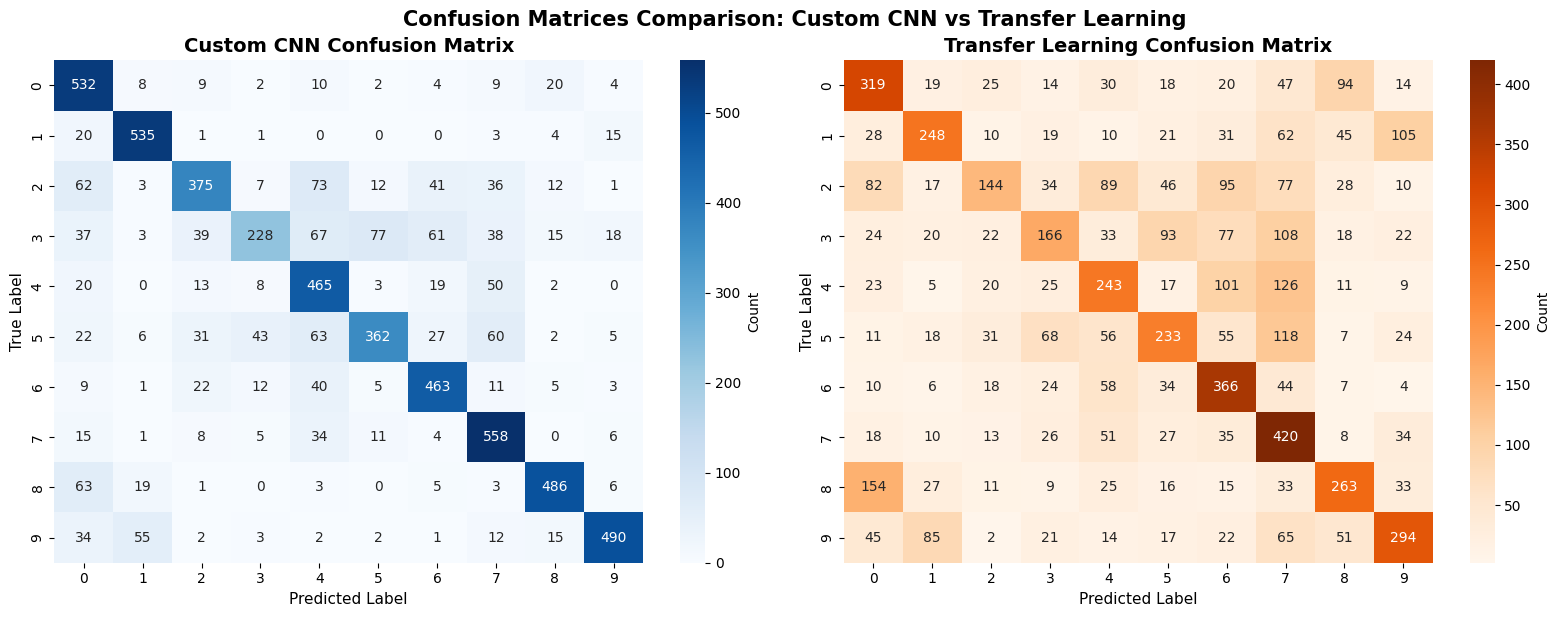

In [76]:
# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Custom CNN Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Custom CNN Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=11)
axes[0].set_ylabel('True Label', fontsize=11)

# Transfer Learning Confusion Matrix
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Oranges', ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('Transfer Learning Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=11)
axes[1].set_ylabel('True Label', fontsize=11)

plt.tight_layout()
plt.suptitle('Confusion Matrices Comparison: Custom CNN vs Transfer Learning', 
             fontsize=15, fontweight='bold', y=1.02)
plt.show()

In [77]:
# Generate and print results
try:
    assignment_results = get_assignment_results() 
    print("\n" + "="*70)
    print("ASSIGNMENT RESULTS SUMMARY (JSON FORMAT)")
    print("="*70)
    print(json.dumps(assignment_results, indent=2))
    print("\n" + "="*70)
    print("✓ Assignment results generated successfully!")
    print("="*70)
except Exception as e:
    print(f"\n⚠ ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")


⚠ ERROR generating results: name 'get_assignment_results' is not defined
Please ensure all variables are properly defined


In [78]:
import sys
import platform
print("\n" + "="*70)
print("ENVIRONMENT INFORMATION")
print("="*70)
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Platform: {platform.platform()}")
print(f"Device: {device}")
print("\n⚠ REQUIRED: Add screenshot of your environment in a markdown cell below")
print("="*70)


ENVIRONMENT INFORMATION
Python Version: 3.14.0 (main, Oct  7 2025, 09:34:52) [Clang 17.0.0 (clang-1700.3.19.1)]
PyTorch Version: 2.9.1
Platform: macOS-26.2-arm64-arm-64bit-Mach-O
Device: cpu

⚠ REQUIRED: Add screenshot of your environment in a markdown cell below


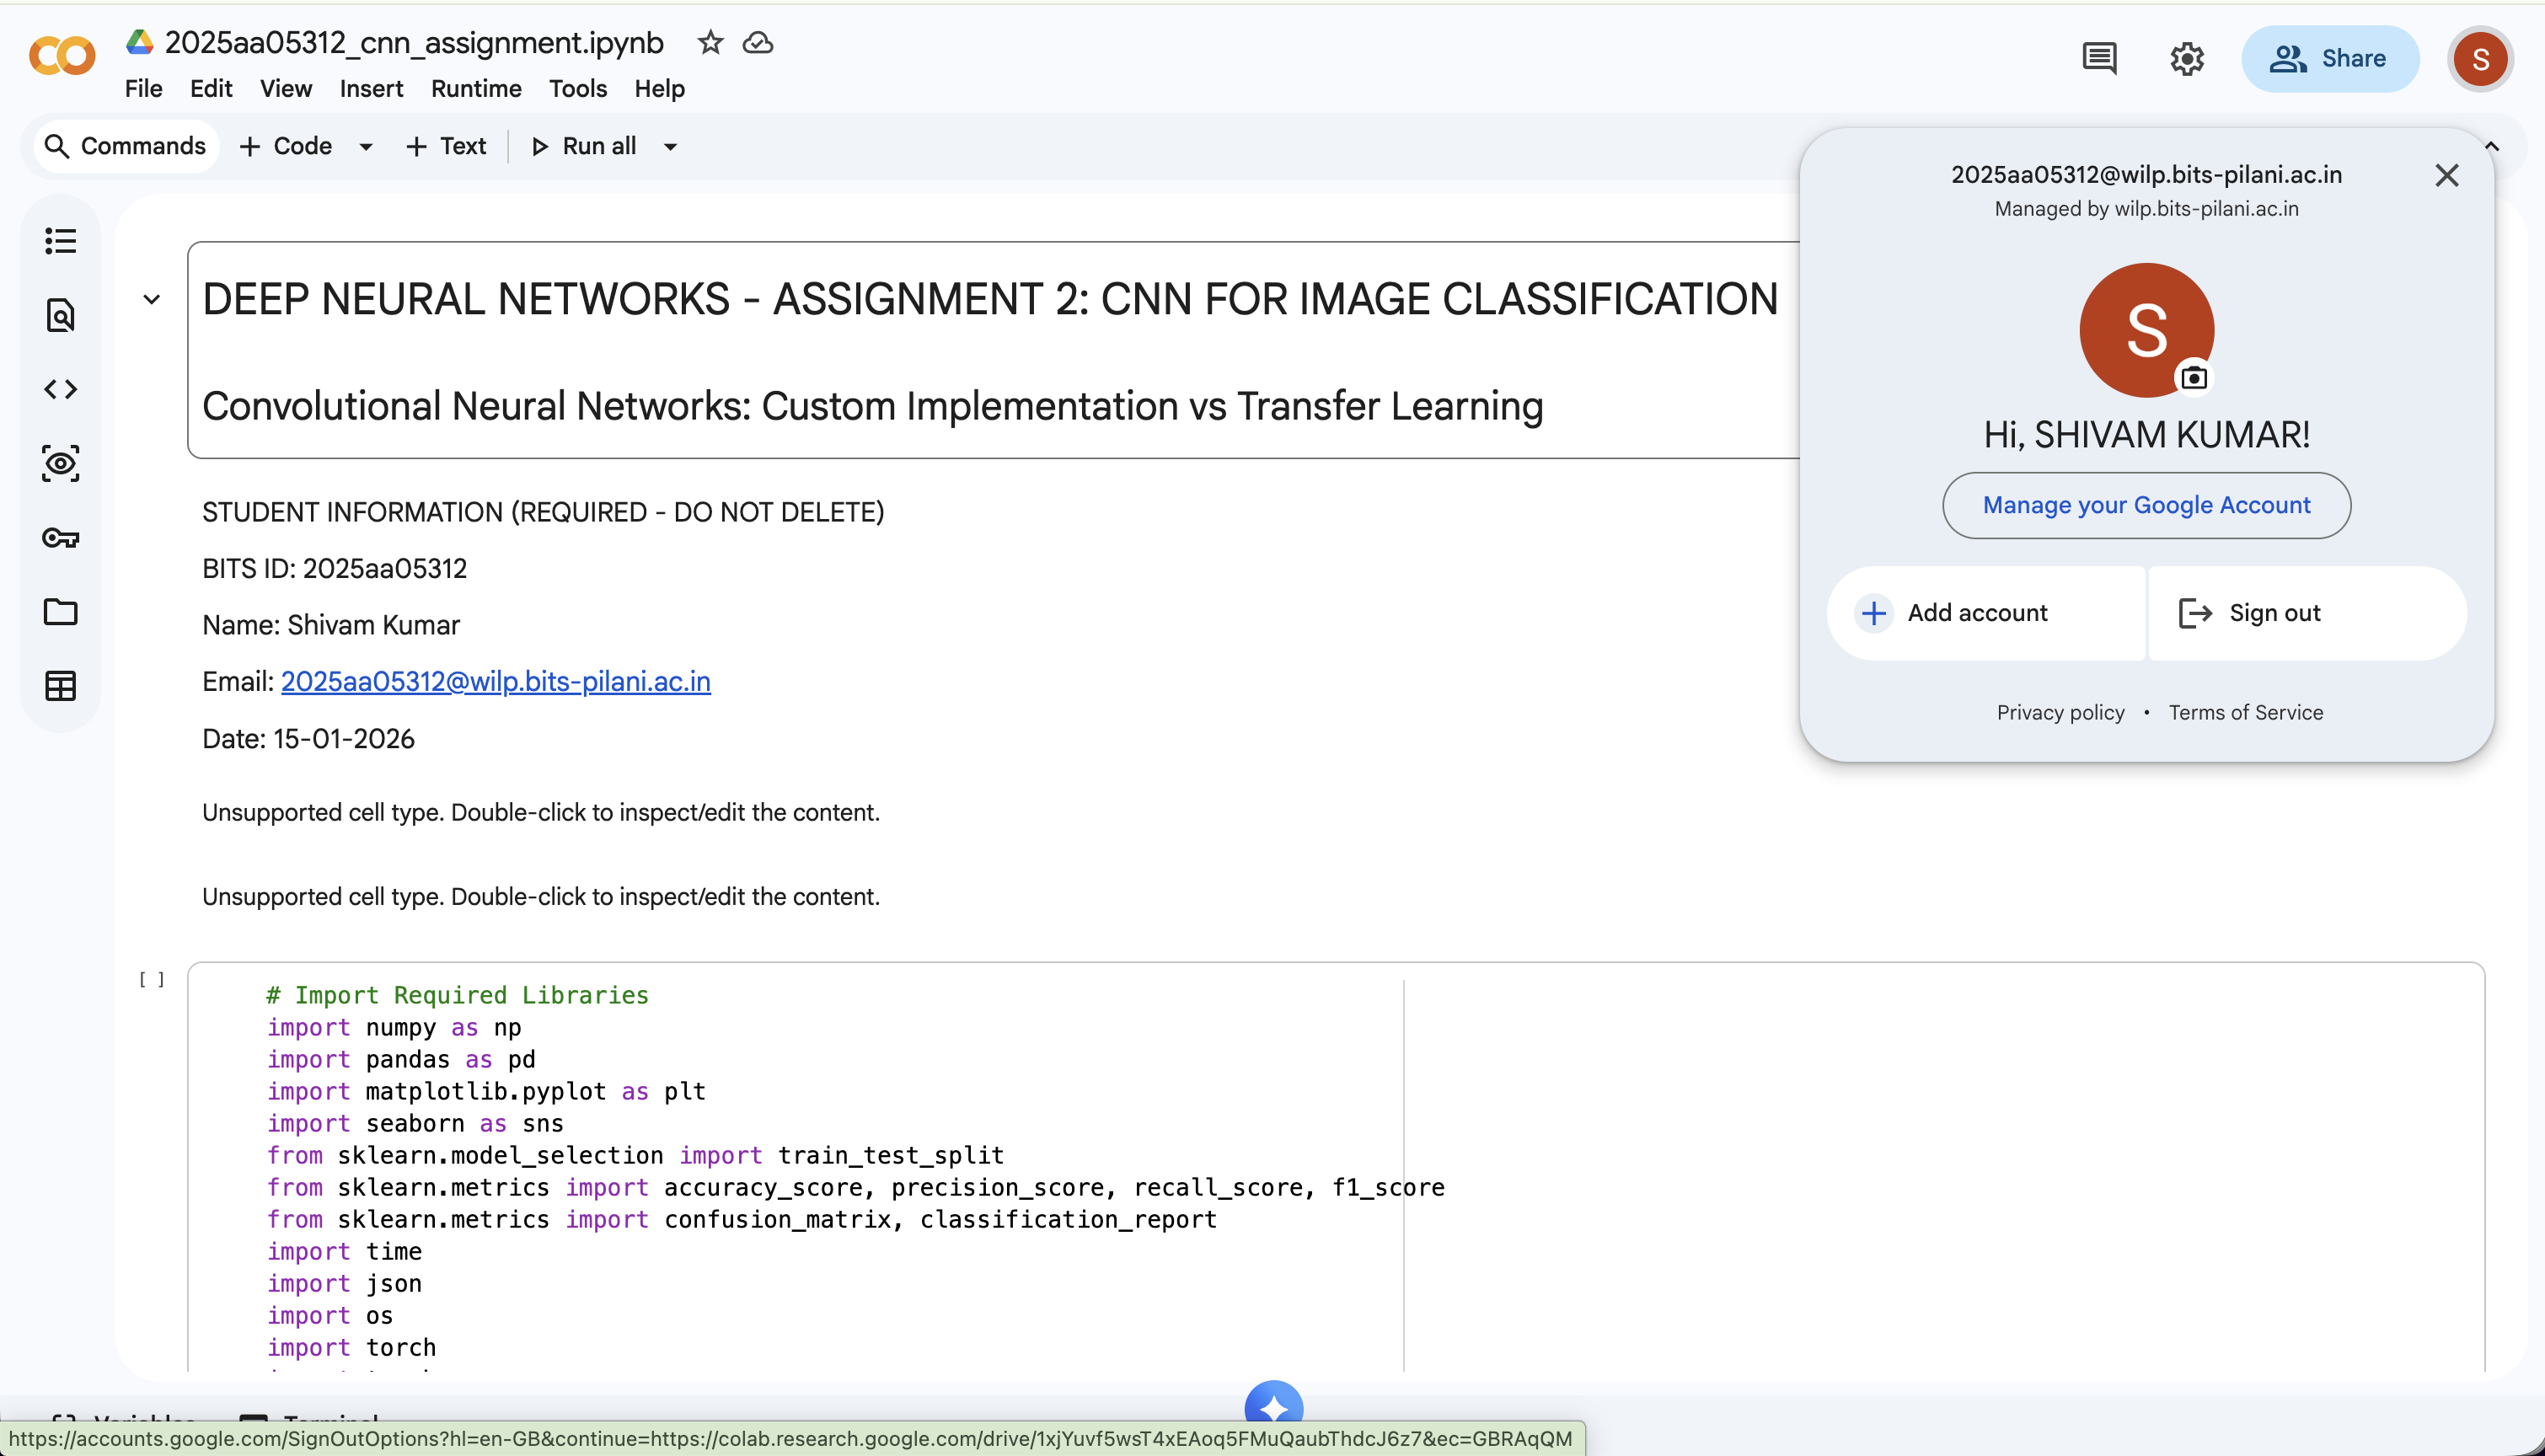

In [83]:
def get_assignment_results():
    """
    Generate complete assignment results in required format
    
    Returns:
        dict: Complete results with all required fields
    """
    
    framework_used = "pytorch" 
    
    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,
        
        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 3,  # 3 conv layers in custom cnn
                'pooling_layers': 3,  # 3 max pools
                'has_global_average_pooling': True, 
                'output_layer': 'linear', # Pytorch uses linear + CrossEntropy
                'total_parameters': sum(p.numel() for p in custom_cnn.parameters()) 
            },
            'training_config': {
                'learning_rate': 0.001, 
                'n_epochs': n_epochs, 
                'batch_size': 32, 
                'optimizer': 'Adam',
                'loss_function': 'CrossEntropyLoss' 
            },
            'initial_loss': custom_cnn_initial_loss,
            'final_loss': custom_cnn_final_loss,
            'training_time_seconds': custom_cnn_training_time,
            'accuracy': custom_cnn_accuracy,
            'precision': custom_cnn_precision,
            'recall': custom_cnn_recall,
            'f1_score': custom_cnn_f1
        },
        
        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True, 
            'total_parameters': total_parameters,
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer,
                'loss_function': 'CrossEntropyLoss'
            },
            'initial_loss': tl_initial_loss,
            'final_loss': tl_final_loss,
            'training_time_seconds': tl_training_time,
            'accuracy': tl_accuracy,
            'precision': tl_precision,
            'recall': tl_recall,
            'f1_score': tl_f1
        },
        
        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),
        
        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss if custom_cnn_initial_loss and custom_cnn_final_loss else False,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss if tl_initial_loss and tl_final_loss else False,
    }
    
    return results

In [84]:
# Generate and print results
try:
    assignment_results = get_assignment_results() 
    print("ASSIGNMENT RESULTS SUMMARY")
    print(json.dumps(assignment_results, indent=2))
    
except Exception as e:
    print(f"\n  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")   

ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "CIFAR-10",
  "dataset_source": "Torchvision / data folder",
  "n_samples": 60000,
  "n_classes": 10,
  "samples_per_class": "avg: 6000",
  "image_shape": [
    32,
    32,
    3
  ],
  "problem_type": "classification",
  "primary_metric": "accuracy",
  "metric_justification": "\nAccuracy is suitable because CIFAR-10 is a balanced dataset with equal samples per class.\n",
  "train_samples": 54000,
  "test_samples": 6000,
  "train_test_ratio": "90/10",
  "custom_cnn": {
    "framework": "pytorch",
    "architecture": {
      "conv_layers": 3,
      "pooling_layers": 3,
      "has_global_average_pooling": true,
      "output_layer": "linear",
      "total_parameters": 94986
    },
    "training_config": {
      "learning_rate": 0.001,
      "n_epochs": 10,
      "batch_size": 32,
      "optimizer": "Adam",
      "loss_function": "CrossEntropyLoss"
    },
    "initial_loss": 2.5356245040893555,
    "final_loss": 0.5614764936250675,
    "train

In [81]:
# Display system information
import platform
import sys
from datetime import datetime

In [82]:
import platform
import sys
from datetime import datetime
import torch
print("ENVIRONMENT INFORMATION")
print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"Platform: {platform.platform()}")
# include the screen shot here (User action)

ENVIRONMENT INFORMATION
Python: 3.14.0 (main, Oct  7 2025, 09:34:52) [Clang 17.0.0 (clang-1700.3.19.1)]
PyTorch: 2.9.1
Platform: macOS-26.2-arm64-arm-64bit-Mach-O
